In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

In [75]:
def getMiscDict(path):
    dirList = path.split('\\')
    syncType = dirList[len(dirList) - 7]
    memoryStorage = dirList[len(dirList) - 6]
    baseline = dirList[len(dirList) -5]
    if baseline == 'Comp':
        baseline = 'TACO'
    elif baseline == 'Async':
        baseline = 'Anti-freeze'
    elif baseline == 'PGImpl':
        baseline = 'NoComp'
    testSpreadsheet = dirList[len(dirList) - 4]
    run = int(dirList[len(dirList) - 3].split('-')[1])
    rows = int(dirList[len(dirList) - 2].split('-')[1])
    return {'Sync/Async':syncType, 'Memory Storage':memoryStorage, 'Baseline':baseline,
            'Test Spreadsheet':testSpreadsheet, 'Run':run, 'Rows':rows}

def getMetrics(path):
    """
    Takes in a path string to a .stat file and returns a Pandas DataFrame of the file's contents
    """
    reportsFile = open(path, 'r')
    dataDict = {}
    dataDict = getMiscDict(path)
    for line in reportsFile:
        if ': ' in line:
            metric, value = line.split(": ")
            if metric not in dataDict:
                dataDict[metric] = []
            try:
                dataDict[metric].append(int(value))
            except ValueError:
                dataDict[metric].append(float(value))
            except:
                dataDict[metric].append(value)
    reportsFile.close
    
    return pd.DataFrame(dataDict)


def getAllMetrics(basePath, miscDict={'sync type':'', 'mem type':'', 'impl':'', 'test':'', 'run':0}):
    """
    Takes in a file path and searches all of its subdirectories for .stat files and returns all of
    their contents in a Pandas DataFrame
    """
    data = pd.DataFrame()
    for file in os.listdir(basePath):
        filePath = os.path.join(basePath, file)
        if os.path.isdir(filePath):
            data = data.append(getAllMetrics(filePath))
        elif file == "core.stat":
            data = data.append(getMetrics(filePath))
    return data


def plotAll(data, 
            sheets=['Rate', 'RunningTotalFast', 'RunningTotalSlow'], 
            memStorage = ['DB', 'IN_MEM'], 
            syncMethod=['async', 'sync'], 
            showTitle=True, 
            outerLegend=True,
            savePlot=False):
    
    plt.rcParams.update({'font.size': 25, 'figure.figsize': (12,8), 'lines.linewidth':3, 'axes.grid':True})
    for sheet in sheets:
        for sync in syncMethod:
            for mem in memStorage:
                try:
                    
                    dataSlice = data.loc[sheet, mem, sync]

                    relevantData = pd.pivot_table(dataSlice, 
                                              index='Rows', 
                                              columns=dataSlice.index)[['Total time to update cells (ms)', 
                                                                        'Total time of adding the batch (ms)']]
                    splitData = [relevantData[relevantData.index < 100000], relevantData[relevantData.index >= 100000]]
                    if len(splitData[1]) == 0:
                        splitData = [splitData[0]]
                    for plotData in splitData:

                        plotTotalTime(plotData, sheet, mem, sync, showTitle, outerLegend, savePlot)
                        plotBatchLoadingTime(plotData, sheet, mem, sync, showTitle, outerLegend, savePlot)
                except:
                    print('error')

                    
                        
def plotTotalTime(plotData, sheet, mem, sync, showTitle, outerLegend, save):
    plt.figure()
    totalTestTimeData = plotData['Total time to update cells (ms)']
    totalTestTimePlot = sns.lineplot(markers=True, markersize=20, ci=None, dashes=False, alpha=.5, color="black", data=totalTestTimeData)
    if (outerLegend):
        handles, labels = totalTestTimePlot.get_legend_handles_labels()
        leg = totalTestTimePlot.legend(
            bbox_to_anchor=(0, 1, 1, 1),
            ncol=3,
            mode="expand",
            loc="lower left",
            handles=handles[0:], 
            labels=labels[0:],
            markerscale=3
        )
    if sync=='sync':
        if showTitle:
            totalTestTimePlot.set_title('Time to Update Spreadsheet (' + sheet + ', ' + sync + ')', pad=70)
        totalTestTimePlot.set_ylabel('Time to Update Spreadsheet (ms)')
    elif sync=='async':
        if showTitle:
            totalTestTimePlot.set_title('Time to Return Control to User (' + sheet + ', ' + sync + ')', pad=70)
        totalTestTimePlot.set_ylabel('Time to Return Control to User (ms)')
    if save: savePlotsavePlot(totalTestTimePlot, sheet, mem, sync, showTitle, outerLegend)
        
def plotBatchLoadingTime(plotData, sheet, mem, sync, showTitle, outerLegend, save):
    if sync=='sync':
        plt.figure()
        batchData = plotData['Total time of adding the batch (ms)']
        yMax = batchData['NoComp'].max()
        cappedData = batchData.copy()
        for column in batchData.columns:
            cappedData[column] = batchData[column].map(lambda x: min(x, yMax * 1.05))
        batchPlot = sns.lineplot(markers=True, markersize=20, ci=None, dashes=False, alpha=.5, color="black", data=cappedData)
        xAdjust = - max(batchData.index.values) * .03
        yAdjust = yMax * .05
        xMax = max(batchData.index.values)
        for column in batchData.columns:
            for i, row in batchData[batchData[column] != cappedData[column]].iterrows():
                xMax = max(batchData.index.values) * 1.14
                batchPlot.text(x=int(row.name) + xAdjust, 
                               y=cappedData.loc[row.name, column] + yAdjust, 
                               s='{:.1e}'.format(row[column]))

        if outerLegend:
            handles, labels = batchPlot.get_legend_handles_labels()
            leg = batchPlot.legend(
                bbox_to_anchor=(0, 1.03, 1, 1),
                ncol=3,
                mode="expand",
                loc="lower left",
                handles=handles[0:], 
                labels=labels[0:],
                markerscale=3
            )
        batchPlot.set_ybound(0 - yMax * .05, yMax * 1.2)
        batchPlot.set_xbound(upper=xMax)
        if showTitle:
            batchPlot.set_title('Batch Loading Time (' + sheet + ')', pad=80) #rename to loading Time
        batchPlot.set_ylabel('Total Time (ms)')
        if save: savePlot(batchPlot, sheet, mem, sync, showTitle, outerLegend)

def savePlot(plot, sheet, mem, sync, showTitle, outerLegend):
    fileString = './plots/'+sheet+'/'+mem+'/'+sync+'/'
    Path(fileString).mkdir(parents=True, exist_ok=True)
    if showTitle:
        fileString += 'WithTitle'
    if outerLegend:
        fileString += 'WithOuterLegend'
    if  not showTitle and not outerLegend:
        fileString += 'Bare'
    
    fileString += '.pdf'
    plt.savefig(fileString, bbox_inches="tight")

error
error
error
error
error
error


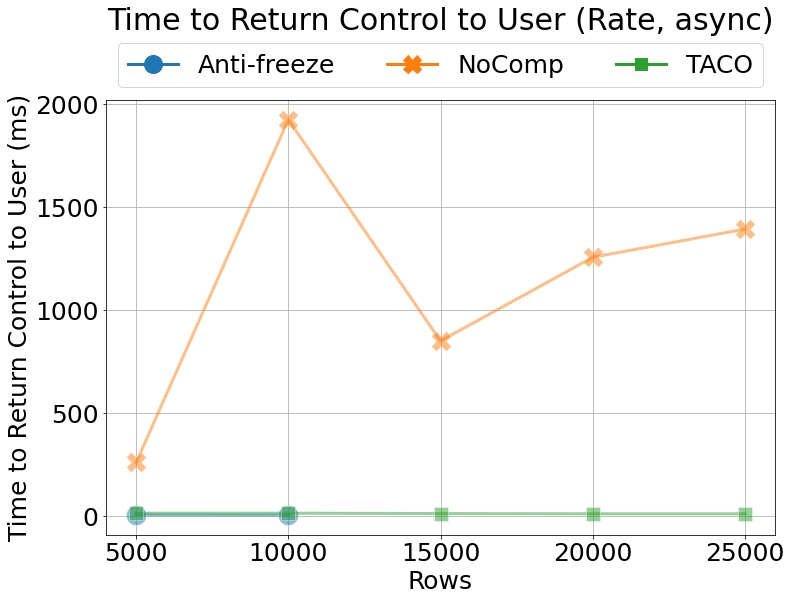

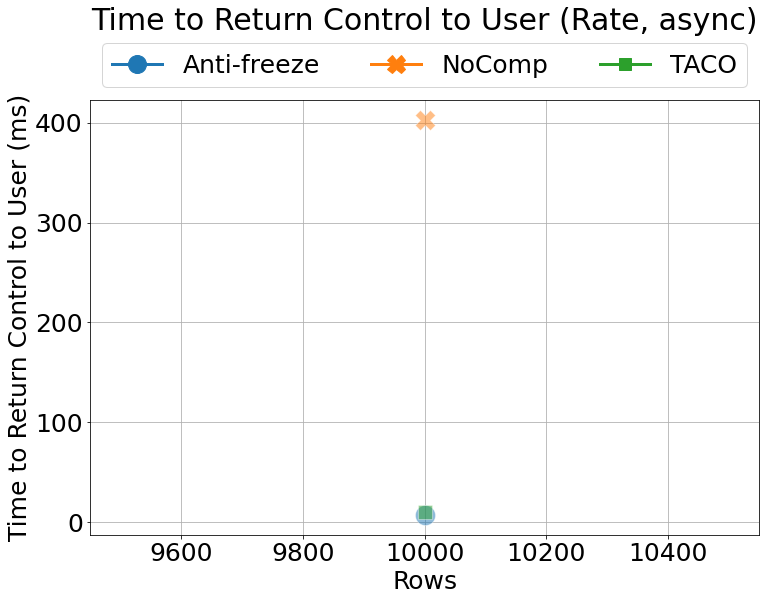

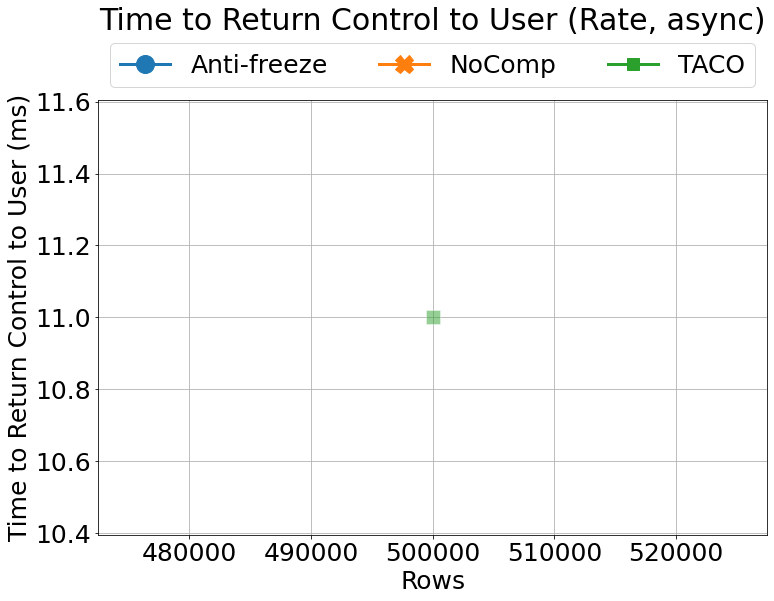

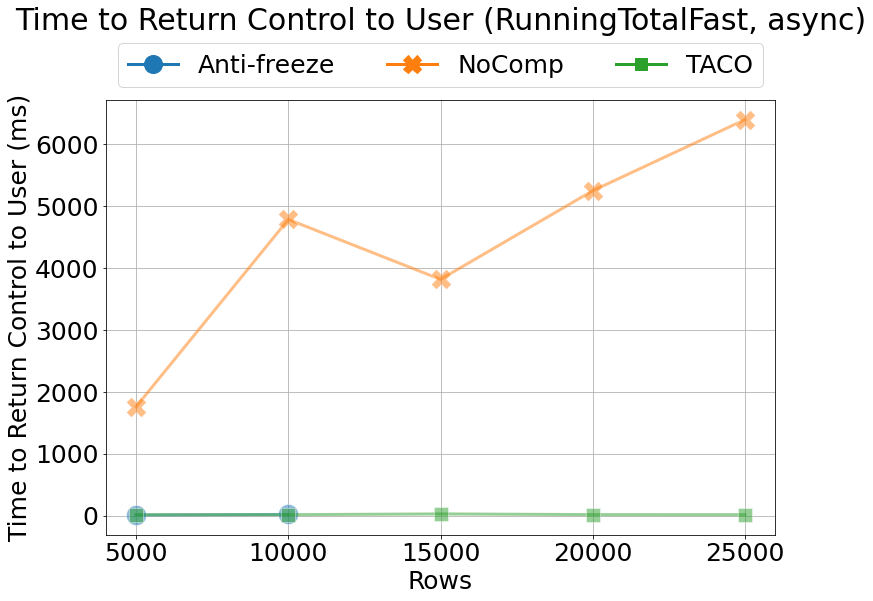

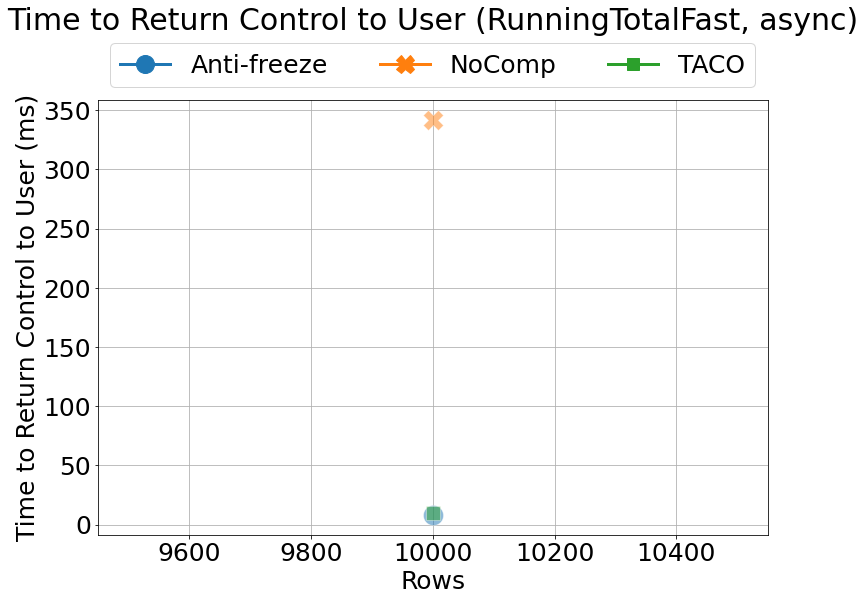

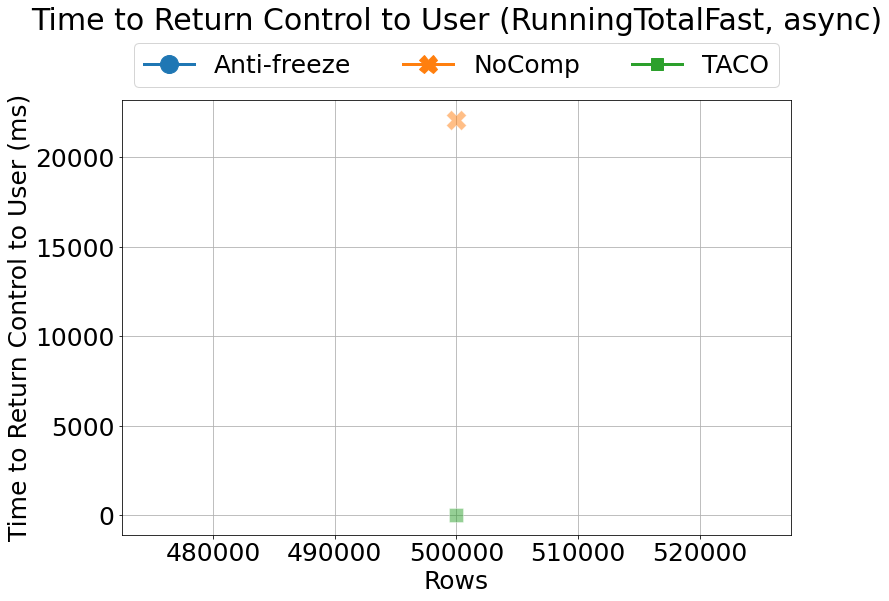

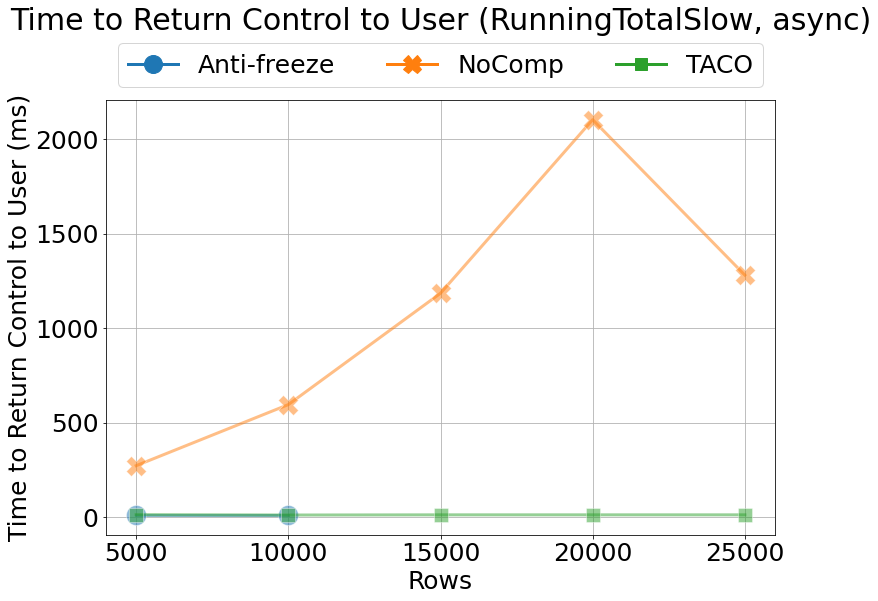

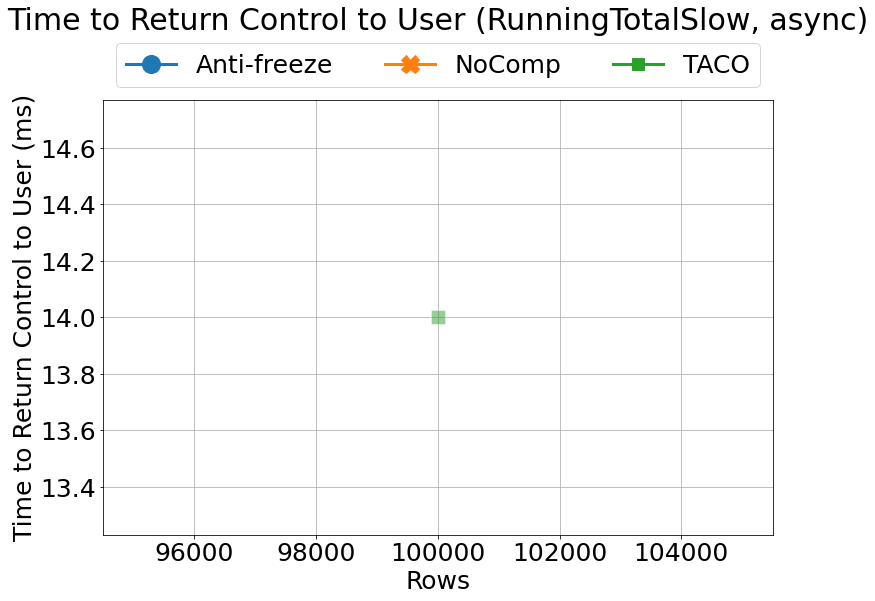

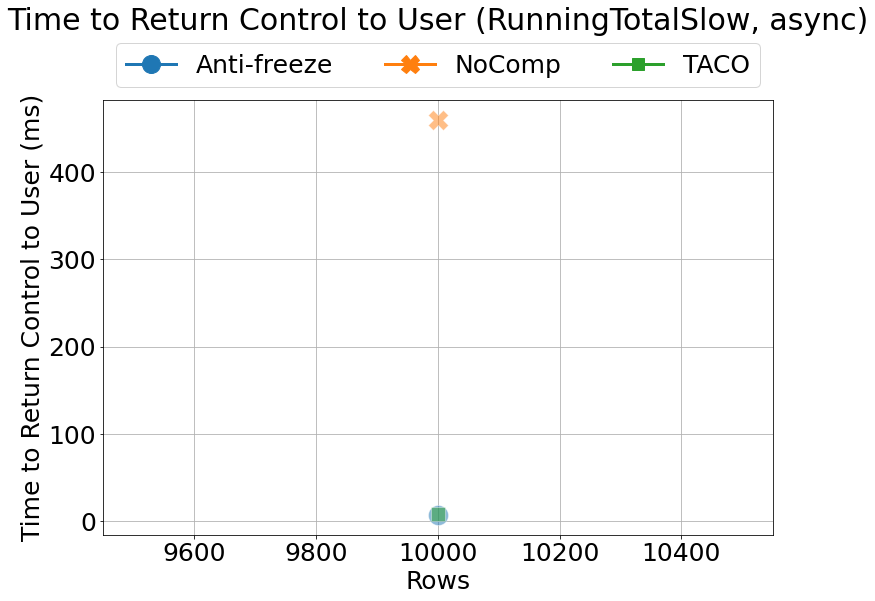

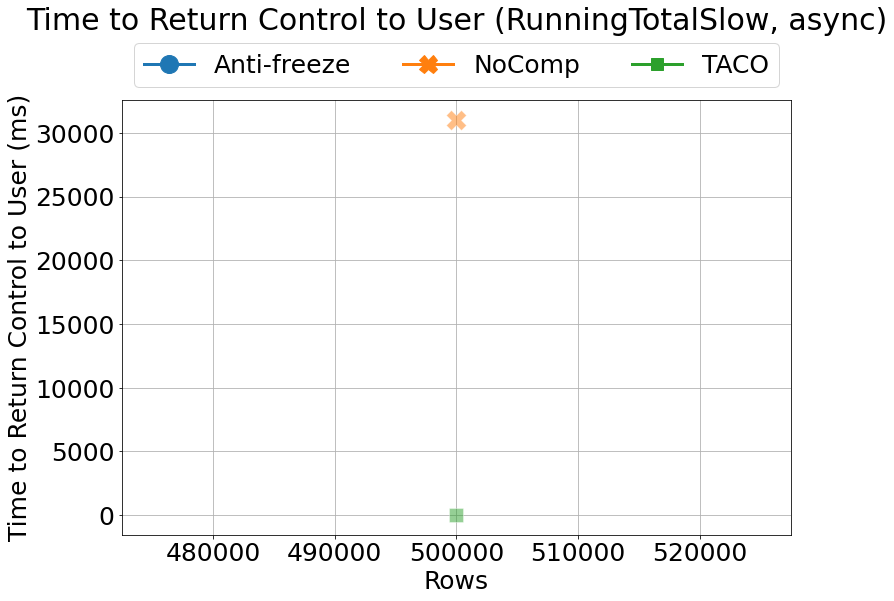

In [76]:
# Formua Compression Test path (CHANGE)
formulaCompressionTestHome = "C:\\Users\\jonat\\Documents\\Dataspread\\FormulaCompressionTest"
testPath = formulaCompressionTestHome + "\\Chris\\FormulaCompressionTesting\\testing\\reports"

pd.set_option('max_rows', 115)
testData = getAllMetrics(testPath)
testData = testData.groupby(['Test Spreadsheet', 'Memory Storage', 'Sync/Async', 'Baseline', 'Rows']).median()
testData = testData.reset_index(level='Rows')
#display(testData)
plotAll(testData, showTitle=True, outerLegend=True)
#plotAll(testData, showTitle=False, outerLegend=True)
#plotAll(testData, showTitle=True, outerLegend=False)
#plotAll(testData, showTitle=False, outerLegend=False)

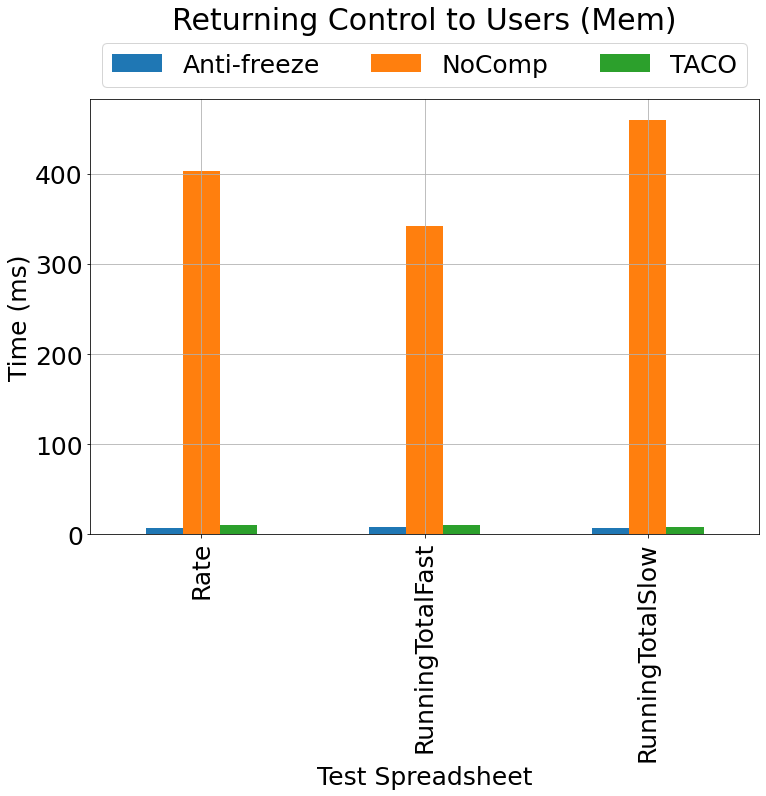

In [89]:
sheets = ['Rate', 'RunningTotalFast', 'RunningTotalSlow']
memStorages = ['DB', 'IN_MEM'] 
syncMethods = ['async', 'sync']
#display(testData)
relevantData = testData[testData['Rows'] == 10000]
#display(relevantData)
relevantData = relevantData.loc[:, 'IN_MEM', 'async']
relevantData = relevantData[relevantData['Rows'] == 10000]
relevantData = relevantData[['Total time to update cells (ms)']]
relevantData = relevantData.reset_index(level=['Test Spreadsheet', 'Baseline']).pivot(index='Test Spreadsheet', columns='Baseline', values='Total time to update cells (ms)')
ax = relevantData.plot.bar()
ax.set_title('Returning Control to Users (Mem)', pad=70)
ax.set_ylabel('Time (ms)')
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(
                bbox_to_anchor=(0, 1, 1, 1),
                ncol=3,
                mode="expand",
                loc="lower left",
                handles=handles[0:], 
                labels=labels[0:],
                markerscale=3
                )

ax.savefig('./plots/other/ReturningControltoUsersBar', bbox_inches="tight")